# Methane flame temperature

In this notebook we adapt this [reference from Cantera](https://cantera.org/examples/jupyter/thermo/flame_temperature.ipynb.html) to compute flame temperature produced by mixing methane and air. This initial estimations are used to check the suitability from current models and kinetics mechanisms to applications to high temperature material processing. Overall combustion equation at unity fuel to oxidizer ratio is

$$
\mathrm{CH_4 + 2 O_2 + 7.52 N_2 \rightarrow 2 H_2O + CO_2 + 7.52 N_2 + \Delta{H}}
$$

In what follows we numerically investigate the role of non-stoichiometric mixing.

We start by configuring the notebook and importing required tools.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]

In [2]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

For complete combustion a filtered version of the mechanism is used so that nominal released heat is found.

A second solution object is created with the whole set of species to compute incomplete combustion.

In [3]:
species_keep = ("CH4", "O2", "CO2", "H2O", "N2", "AR")
species_full = {s.name: s for s in ct.Species.listFromFile("gri30.yaml")}
species_calc = [species_full[s] for s in species_keep]

gas1 = ct.Solution(thermo="IdealGas", species=species_calc)
gas2 = ct.Solution(thermo="IdealGas", species=species_full.values())
gas3 = ct.Solution("../databases/kinetics/2S_CH4_BFER.cti")

Equilibrium under constant enthalpy and pressure is evaluated for $\phi\in[0.5;2.5]$ with air as oxidizer.

The [lower heating value (LHV)](https://en.wikipedia.org/wiki/Heat_of_combustion#Lower_heating_value) is also computed as described [here](https://cantera.org/examples/jupyter/thermo/heating_value.ipynb.html).

In [4]:
TP = 298.15, ct.one_atm

X_fuel = "CH4:1.0"
X_oxid = "O2:0.21, N2:0.78, AR:0.01"

phi = np.linspace(0.5, 2.0, 100)

T_complete1 = np.zeros_like(phi)
T_complete3 = np.zeros_like(phi)
T_incomplete = np.zeros_like(phi)

X_complete1 = np.zeros_like(phi)
X_complete3 = np.zeros_like(phi)
X_incomplete = np.zeros_like(phi)

lhv_complete1 = np.zeros_like(phi)
lhv_complete3 = np.zeros_like(phi)
lhv_incomplete = np.zeros_like(phi)

for k, phik in enumerate(phi):
    gas1.TP = TP
    gas2.TP = TP
    gas3.TP = TP

    gas1.set_equivalence_ratio(phik, X_fuel, X_oxid, basis="mole")
    gas2.set_equivalence_ratio(phik, X_fuel, X_oxid, basis="mole")
    gas3.set_equivalence_ratio(phik, X_fuel, X_oxid, basis="mole")

    h0_1 = gas1.enthalpy_mass
    h0_2 = gas2.enthalpy_mass
    h0_3 = gas3.enthalpy_mass
    
    y_fuel1 = gas1["CH4"].Y[0]
    y_fuel2 = gas2["CH4"].Y[0]
    y_fuel3 = gas3["CH4"].Y[0]
    
    gas1.equilibrate("HP", solver="vcs", max_steps=10_000, max_iter=1000, log_level=0)
    gas2.equilibrate("HP", solver="vcs", max_steps=10_000, max_iter=1000, log_level=0)
    gas3.equilibrate("HP", solver="vcs", max_steps=10_000, max_iter=1000, log_level=0)

    T_complete1[k] = gas1.T
    T_complete3[k] = gas3.T
    T_incomplete[k] = gas2.T

    X_complete1[k] = gas1.mole_fraction_dict()["O2"]
    X_complete3[k] = gas3.mole_fraction_dict()["O2"]
    X_incomplete[k] = gas2.mole_fraction_dict()["O2"]
    
    gas1.TP = TP
    gas2.TP = TP
    gas3.TP = TP
    
    h1_1 = gas1.enthalpy_mass
    h1_2 = gas2.enthalpy_mass
    h1_3 = gas2.enthalpy_mass
    
    lhv_complete1[k] = -(h1_1 - h0_1) / (y_fuel1 * 1e6)
    lhv_complete3[k] = -(h1_3 - h0_3) / (y_fuel3 * 1e6)
    lhv_incomplete[k] = -(h1_2 - h0_2) / (y_fuel2 * 1e6)

Plotting it all together one verify good agreement with the reference above, thus validating the model.

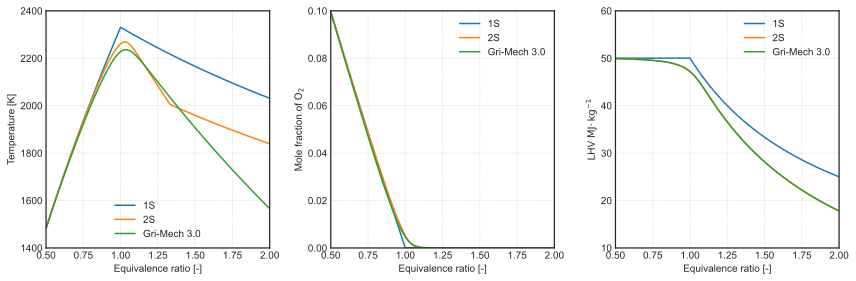

In [5]:
plt.close("all")
plt.style.use("seaborn-white")
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(phi, T_complete1, label="1S")
ax[0].plot(phi, T_complete3, label="2S")
ax[0].plot(phi, T_incomplete, label="Gri-Mech 3.0")
ax[0].grid(linestyle=":")
ax[0].set_xlabel("Equivalence ratio [-]")
ax[0].set_ylabel("Temperature [K]")
ax[0].set_xlim(0.5, 2.0)
ax[0].set_ylim(1400, 2400)
ax[0].legend()

ax[1].plot(phi, X_complete1, label="1S")
ax[1].plot(phi, X_complete3, label="2S")
ax[1].plot(phi, X_incomplete, label="Gri-Mech 3.0")
ax[1].grid(linestyle=":")
ax[1].set_xlabel("Equivalence ratio [-]")
ax[1].set_ylabel("Mole fraction of $\mathrm{O_2}$")
ax[1].set_xlim(0.5, 2.0)
ax[1].set_ylim(0.0, 0.1)
ax[1].legend()

ax[2].plot(phi, lhv_complete1, label="1S")
ax[2].plot(phi, lhv_complete3, label="2S")
ax[2].plot(phi, lhv_incomplete, label="Gri-Mech 3.0")
ax[2].grid(linestyle=":")
ax[2].set_xlabel("Equivalence ratio [-]")
ax[2].set_ylabel("LHV $\mathrm{MJ\cdotp{}kg^{-1}}$")
ax[2].set_xlim(0.5, 2.0)
ax[2].set_ylim(10.0, 60.0)
ax[2].legend()

fig.tight_layout()

Once checked the energetic suitability of the model, we proceed with combustion delay evaluation for incomplete combustion.

This choice is the reasonable one for actual applications given the deviations from ideal behavior.

Here as assume ignition delay is measured by the peak of a reference radical species.

In [6]:
def ignition_delay(states, species):
    """ Ignition delay from peak in species concentration. """
    return states.t[states(species).Y.argmax()]

In [7]:
def make_simulation(gas, max_time_step=0.001, atol=1.0e-15, rtol=1.0e-10):
    """ Create reactor for ignition time simulation. """
    reactor = ct.IdealGasConstPressureReactor(gas)
    reactor.volume = 1.0
    reactor.chemistry_enabled = True
    reactor.energy_enabled = True

    network = ct.ReactorNet([reactor])
    network.max_time_step = max_time_step
    network.atol = atol
    network.rtol = rtol

    return network, reactor

Computation is performed in a closed constant pressure reactor starting at the same temperature as reference paper.

Solution is advanced in time using internal time-step size over the interval expected to capture ignition.

In [8]:
reference_species = "OH"
estimated_ignition_delay_time = 0.1
phi = 1.0

gas = ct.Solution("gri30.yaml")
gas.TP = 1200.0, ct.one_atm
gas.set_equivalence_ratio(phi, X_fuel, X_oxid, basis="mole")

network, reactor = make_simulation(gas)
time_history = ct.SolutionArray(gas, extra="t")

t = 0
time_history.append(reactor.thermo.state, t=t)

while t < estimated_ignition_delay_time:
    t = network.step()
    time_history.append(reactor.thermo.state, t=t)

tau = ignition_delay(time_history, reference_species) * 1e3

We recover the ignition time as reported by [Zhao et al. (2011)](https://doi.org/10.1007/s11434-010-4345-3) for reference.

The next plot illustrates good agreement even though simulation was not carried with same mechanism.

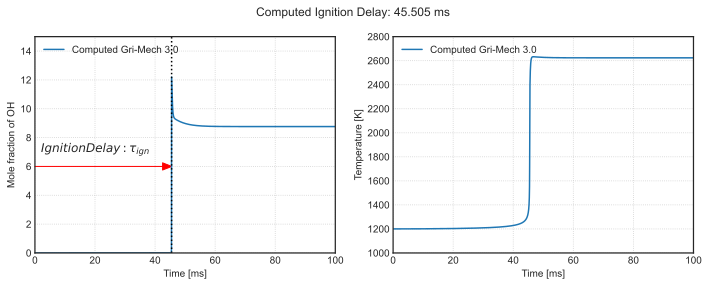

In [9]:
t = time_history.t * 1e3
T = time_history.T
Y = time_history(reference_species).Y * 1e3

plt.close("all")
plt.style.use("seaborn-white")
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f"Computed Ignition Delay: {tau:.3f} ms")

ax[0].plot(t, Y, label="Computed Gri-Mech 3.0")
ax[0].grid(linestyle=":")
ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Mole fraction of $\mathrm{OH}$")
ax[0].set_xlim(0.0, 100.0)
ax[0].set_ylim(0.0, 15.0)
ax[0].legend(loc=2)

ax[0].axvline(tau, linestyle=":", color="k")
ax[0].arrow(0.0, 6.0, tau, 0.0, width=0.001,
            head_width=0.5, head_length=3.0,
            length_includes_head=True, color="r",
            shape="full")
ax[0].annotate(r"$Ignition Delay: \tau_{ign}$", xy=(0, 0), 
               xytext=(2, 7), fontsize=12)

ax[1].plot(t, T, label="Computed Gri-Mech 3.0")
ax[1].grid(linestyle=":")
ax[1].set_xlabel("Time [ms]")
ax[1].set_ylabel("Temperature [K]")
ax[1].set_xlim(0.0, 100.0)
ax[1].set_ylim(1000.0, 2800.0)
ax[1].legend(loc=2)

fig.tight_layout()

Another important element to show is the negative temperature coefficient (NTC) of the mechanism.

This is shown by demonstrating a faster combustion with increased initial temperature.

In [10]:
T = np.arange(2000, 999, -25)

estimated_ignition_delay_times = 0.1 * np.ones_like(T, dtype=float)

extra = {"tau": estimated_ignition_delay_times}
ignition_delays = ct.SolutionArray(gas, shape=T.shape, extra=extra)
ignition_delays.set_equivalence_ratio(phi, X_fuel, X_oxid, basis="mole")
ignition_delays.TP = T, ct.one_atm

A scan is performed over all array elements to compute ignition delays.

In [11]:
for k, state in enumerate(ignition_delays):
    gas.TPX = state.TPX
    network, reactor = make_simulation(gas)
    reference_species_history = []
    time_history = []

    t = 0
    while t < estimated_ignition_delay_times[k]:
        t = network.step()
        time_history.append(t)
        reference_species_history.append(gas[reference_species].X[0])

    i_ign = np.array(reference_species_history).argmax()
    ignition_delays.tau[k] = time_history[i_ign] * 1e3

The following plot displays the characteristic curve for NTC checks.

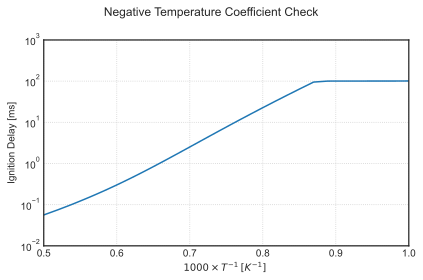

In [12]:
plt.close("all")
plt.style.use("seaborn-white")
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
fig.suptitle(f"Negative Temperature Coefficient Check")
ax.semilogy(1000 / ignition_delays.T, ignition_delays.tau)
ax.grid(linestyle=":")
ax.set_ylabel("Ignition Delay [ms]")
ax.set_xlabel("$1000\\times{}T^{-1}\:[K^{-1}]$ ")
ax.set_xlim(0.5, 1.0)
ax.set_ylim(0.01, 1000.0)
fig.tight_layout()